# Financial Fraud Detection by Using LSTM Autoencoder

+ Dataset: https://www.kaggle.com/datasets/kartik2112/fraud-detection/data?select=fraudTrain.csv

I imported the dataset from Kaggle, it is designed for Credit Card Transactions Fraud Detection. Here are some initial features of the dataset:

+ category - Category of Merchant
+ amt - Amount of Transaction
+ first - First Name of Credit Card Holder
+ last - Last Name of Credit Card Holder
+ gender - Gender of Credit Card Holder
+ street - Street Address of Credit Card Holder
+ city - City of Credit Card Holder
+ state - State of Credit Card Holder
+ zip - Zip of Credit Card Holder
+ lat - Latitude Location of Credit Card Holder
+ long - Longitude Location of Credit Card Holder
+ city_pop - Credit Card Holder's City Population
+ job - Job of Credit Card Holder
+ dob - Date of Birth of Credit Card Holder
+ trans_num - Transaction Number
+ unix_time - UNIX Time of transaction
+ merch_lat - Latitude Location of Merchant
+ merch_long - Longitude Location of Merchant
+ is_fraud - Fraud Flag <--- Target Class

In [6]:
# !pip install opendatasets --upgrade --quiet

In [7]:
#  import opendatasets as od

In [8]:
# dataset_url = 'https://www.kaggle.com/datasets/kartik2112/fraud-detection'
# od.download(dataset_url)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from math import radians, sin, cos, sqrt, atan2
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

In [10]:
df = pd.read_csv("/Users/hau.nguyen2904/Downloads/fraudTrain.csv")
df.drop(columns = [df.columns[0], df.columns[2], df.columns[6], df.columns[7], df.columns[9],  "trans_num"], inplace=True)


df.head()

,trans_date_trans_time,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,1325376186,38.674999,-78.632459,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   merchant               1296675 non-null  object 
 2   category               1296675 non-null  object 
 3   amt                    1296675 non-null  float64
 4   gender                 1296675 non-null  object 
 5   city                   1296675 non-null  object 
 6   state                  1296675 non-null  object 
 7   zip                    1296675 non-null  int64  
 8   lat                    1296675 non-null  float64
 9   long                   1296675 non-null  float64
 10  city_pop               1296675 non-null  int64  
 11  job                    1296675 non-null  object 
 12  dob                    1296675 non-null  object 
 13  unix_time              1296675 non-null  int64  
 14  merch_lat         

In [12]:
df.isnull().sum()

trans_date_trans_time    0
merchant                 0
category                 0
amt                      0
gender                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [13]:
class_counts = df['is_fraud'].value_counts()

class_distribution = class_counts / len(df)
class_distribution

is_fraud
0    0.994211
1    0.005789
Name: count, dtype: float64

## 1. Feature Engineering

### Age

Let's calculate the age of the credit card holder based on their date of birth from the available features.

In [14]:
current_date = datetime.now()
current_date = pd.to_datetime(current_date)
current_year = current_date.year
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = current_year - df['dob'].dt.year

In [15]:
df.drop(columns = ["dob"], inplace = True)

### Distance

Let's calculate the Distance between the merchant and the customer using Haversine distance formula.

In [16]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1_rad, lon1_rad = radians(lat1), radians(lon1)
    lat2_rad, lon2_rad = radians(lat2), radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [17]:
df["distance"] = df.apply(lambda row: haversine_distance(row['lat'], row['long'], 
                                                         row['merch_lat'], row['merch_long']), axis=1)

In [18]:
df.drop(columns = ["lat", "long", "merch_lat", "merch_long"], inplace = True)
df.head()

,trans_date_trans_time,merchant,category,amt,gender,city,state,zip,city_pop,job,unix_time,is_fraud,age,distance
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,28654,3495,"Psychologist, counselling",1325376018,0,36,78.597568
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,99160,149,Special educational needs teacher,1325376044,0,46,30.212176
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,83252,4154,Nature conservation officer,1325376051,0,62,108.206083
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,59632,1939,Patent attorney,1325376076,0,57,95.673231
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,24433,99,Dance movement psychotherapist,1325376186,0,38,77.556744


### Merchant

Let's calculate fraud percentages for each merchant

In [19]:
merchant_groups = df.groupby('merchant')
fraud_percentage_dict = {}

for merchant, group in merchant_groups:
    total_trans = group.shape[0]
    total_fraud_trans = group[group["is_fraud"] == 1].shape[0]
    fraud_percentage_dict[merchant] = (total_fraud_trans / total_trans) * 100


df["fraud_merchant_pct"] = df["merchant"].map(fraud_percentage_dict)


Let's rank merchants based on their fraud percentages using merchant ordinals

In [20]:
sorted_fraud_percentage = sorted(fraud_percentage_dict.items(), key=lambda x: x[1])

# Create a dictionary for ordinal encoding
merchant_ordinal_dict = {merchant: rank + 1 for rank, (merchant, _) in enumerate(sorted_fraud_percentage)}

df["merchant_ordinal"] = df["merchant"].map(merchant_ordinal_dict)

### States

Encode the states, then create a figure to rank the number of fraud transactions by state.

In [21]:
state_freq = df['state'].value_counts(normalize=True)
df['state_encoded'] = df['state'].map(state_freq)

In [22]:
df.head()

,trans_date_trans_time,merchant,category,amt,gender,city,state,zip,city_pop,job,unix_time,is_fraud,age,distance,fraud_merchant_pct,merchant_ordinal,state_encoded
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,28654,3495,"Psychologist, counselling",1325376018,0,36,78.597568,1.420679,599,0.023341
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,99160,149,Special educational needs teacher,1325376044,0,46,30.212176,1.078706,557,0.014594
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,83252,4154,Nature conservation officer,1325376051,0,62,108.206083,0.211082,215,0.004276
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,59632,1939,Patent attorney,1325376076,0,57,95.673231,0.344432,368,0.009065
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,24433,99,Dance movement psychotherapist,1325376186,0,38,77.556744,0.376884,399,0.022558


In [23]:
fraud_by_state = df[df['is_fraud'] == 1].groupby('state').size()
fraud_by_state = fraud_by_state.sort_values(ascending=False)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


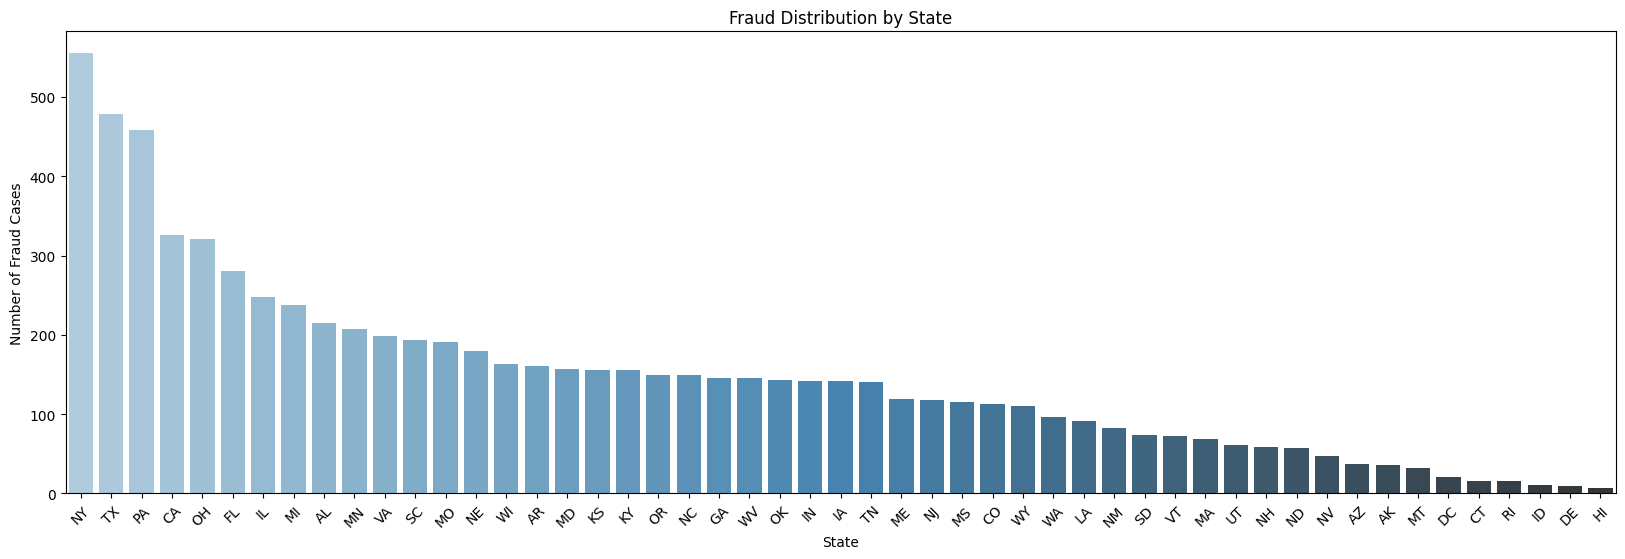

In [24]:
plt.figure(figsize=(20, 6))
sns.barplot(x=fraud_by_state.index, y=fraud_by_state.values, palette='Blues_d')
plt.title('Fraud Distribution by State')
plt.xlabel('State')
plt.ylabel('Number of Fraud Cases')
plt.xticks(rotation=45)
plt.show()

### Jobs

There are 494 non-unique jobs, so I need to categorize them into job categories.

In [25]:
df.job.nunique()

494

In [26]:
sector_bag = {
    "IT": ["engineer", "developer", "programmer", "software", "IT", "technician", "architect", "system", "network",
           "administrator", "data scientist", "cybersecurity", "web developer", "analyst", "database", "devops"],

    "Education": ["teacher", "professor", "educator", "trainer", "lecturer", "scientist", "Orthoptist", "tutor",
                  "principal", "instructor", "counselor", "academic", "researcher", "dean", "school", "headmaster"],

    "Healthcare": ["doctor", "nurse", "medical", "therapist", "pharmacist", "health", "surgeon", "dentist", "clinician",
                   "physician", "optometrist", "radiologist", "paramedic", "midwife", "veterinarian", "psychiatrist"],

    "Finance": ["analyst", "accountant", "auditor", "banker", "financial", "investment", "controller", "broker",
                "consultant", "treasurer", "loan officer", "trader", "actuary", "economist", "portfolio", "credit"],

    "Marketing": ["manager", "executive", "specialist", "consultant", "advertising", "public relations", "strategist",
                  "director", "coordinator", "brand", "SEO", "content", "digital", "market research", "social media",
                  "copywriter"],

    "Manufacturing": ["operator", "mechanic", "assembler", "fabricator", "engineer", "technician", "welder",
                      "planner", "quality", "machinist", "production", "inspector", "supervisor", "foreman",
                      "toolmaker", "CNC"],

    "Retail": ["cashier", "salesperson", "store", "associate", "manager", "clerk", "shopkeeper", "merchandiser",
               "assistant", "retail", "customer service", "sales", "inventory", "buyer", "stocker", "checkout"],

    "Legal": ["lawyer", "attorney", "paralegal", "judge", "legal", "solicitor", "notary", "clerk", "litigator",
              "advocate", "barrister", "counsel", "magistrate", "prosecutor", "defense", "compliance"],

    "Hospitality": ["chef", "waiter", "bartender", "host", "manager", "receptionist", "housekeeper", "concierge",
                    "caterer", "cook", "hotel", "tour guide", "event planner", "sous chef", "sommelier", "valet"],

    "Construction": ["builder", "carpenter", "electrician", "plumber", "architect", "project manager", "site manager",
                     "surveyor", "foreman", "bricklayer", "roofer", "civil engineer", "construction", "contractor",
                     "inspector", "draftsman"]
}

def assign_sector(x):
    for key in sector_bag:
        for role in sector_bag[key]:
            if x.find(role) != -1:
                return key
    return "Other"

In [27]:
df["job_sector"] = df["job"].apply(assign_sector)
job = df["job_sector"].value_counts().reset_index()


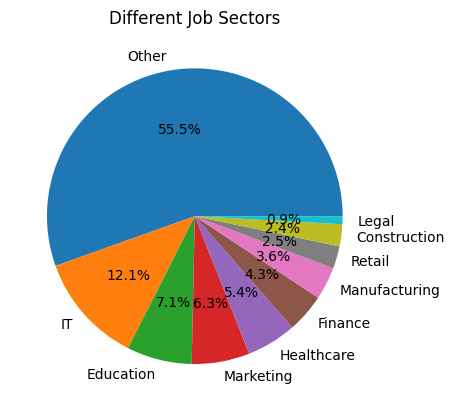

In [28]:
plt.pie(x = job.get("count"), labels = job.get("job_sector"),autopct='%1.1f%%')
plt.title("Different Job Sectors")
plt.show()

In [29]:
job_freq = df['job'].value_counts(normalize=True)
df['job_encoded'] = df['job'].map(job_freq)

In [30]:
df.head()

,trans_date_trans_time,merchant,category,amt,gender,city,state,zip,city_pop,job,unix_time,is_fraud,age,distance,fraud_merchant_pct,merchant_ordinal,state_encoded,job_sector,job_encoded
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,28654,3495,"Psychologist, counselling",1325376018,0,36,78.597568,1.420679,599,0.023341,Legal,0.002734
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,99160,149,Special educational needs teacher,1325376044,0,46,30.212176,1.078706,557,0.014594,Education,0.003932
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,83252,4154,Nature conservation officer,1325376051,0,62,108.206083,0.211082,215,0.004276,Other,0.000394
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,59632,1939,Patent attorney,1325376076,0,57,95.673231,0.344432,368,0.009065,Legal,0.001951
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,24433,99,Dance movement psychotherapist,1325376186,0,38,77.556744,0.376884,399,0.022558,Healthcare,0.001556


### Genders

Let's convert the gender from Male/Female to 1/0

In [31]:
df["gender"] = df["gender"].apply(lambda x: int(x == "M"))

In [32]:
gender_counts = df['gender'].value_counts()
gender_counts.index = gender_counts.index.map({1: 'Male', 0: 'Female'})


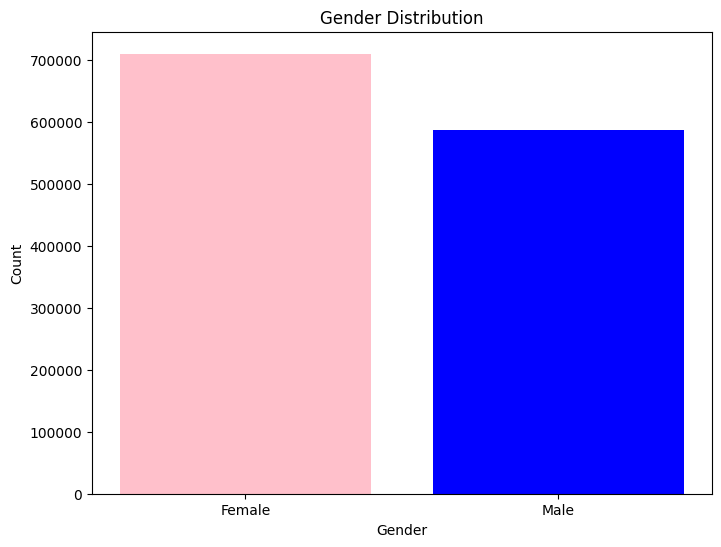

In [33]:
plt.figure(figsize=(8, 6))
plt.bar(gender_counts.index, gender_counts.values, color=['pink', 'blue'])

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

## Dates

Let's find out the weekend and period of a day

In [34]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])

In [35]:
df["is_weekend"] = df["trans_date_trans_time"].dt.day_name().apply(lambda x : int((x == "Friday") | (x == "Sunday") | (x == "Saturday")))

In [36]:
def day_period(x):
    if x >=0 and x < 6: return "Night"
    elif x>= 6 and x <= 12: return "Morning"
    elif x> 12 and x <= 15: return "Afternoon"
    elif x> 15 and x <= 20: return "Evening"
    elif x> 20 and x <= 24: return "Night"


df["day_period"] = df["trans_date_trans_time"].dt.hour.apply(day_period)

In [37]:
df["trans_month"] = df["trans_date_trans_time"].dt.month_name()

In [38]:
df.drop(columns = ["state", "city", "merchant", "zip", "unix_time", "job", "trans_date_trans_time"], inplace = True)
df.head()

,category,amt,gender,city_pop,is_fraud,age,distance,fraud_merchant_pct,merchant_ordinal,state_encoded,job_sector,job_encoded,is_weekend,day_period,trans_month
0,misc_net,4.97,0,3495,0,36,78.597568,1.420679,599,0.023341,Legal,0.002734,0,Night,January
1,grocery_pos,107.23,0,149,0,46,30.212176,1.078706,557,0.014594,Education,0.003932,0,Night,January
2,entertainment,220.11,1,4154,0,62,108.206083,0.211082,215,0.004276,Other,0.000394,0,Night,January
3,gas_transport,45.00,1,1939,0,57,95.673231,0.344432,368,0.009065,Legal,0.001951,0,Night,January
4,misc_pos,41.96,1,99,0,38,77.556744,0.376884,399,0.022558,Healthcare,0.001556,0,Night,January


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


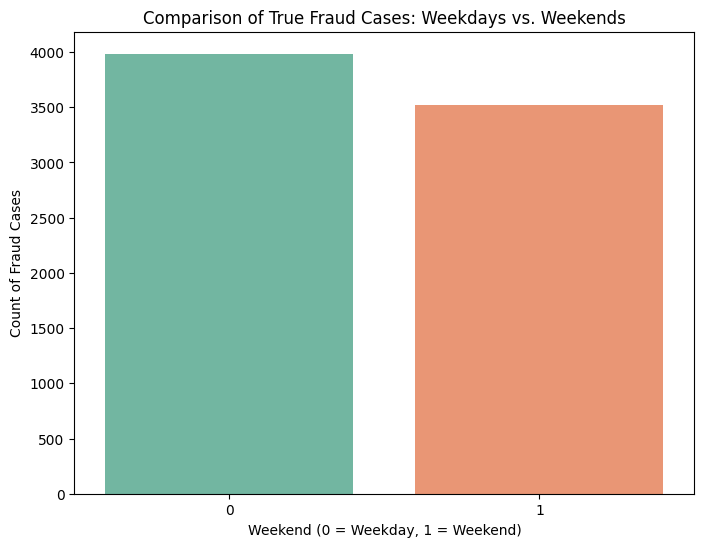

In [40]:
fraud_df = df[df['is_fraud'] == 1]

# Create a count plot to visualize the number of fraud cases by weekend status
plt.figure(figsize=(8, 6))
sns.countplot(x='is_weekend', data=fraud_df, palette='Set2')

# Add labels and title
plt.title('Comparison of True Fraud Cases: Weekdays vs. Weekends')
plt.xlabel('Weekend (0 = Weekday, 1 = Weekend)')
plt.ylabel('Count of Fraud Cases')

# Show the plot
plt.show()

Findings: Even though the weekend is split into 3 days (Fri, Sat, Sun), the number of fraud cases is still lower than on weekdays, by around 500 cases

## Vizualization

Let's split the dataset into 2 types: numerical type and categorical type

In [55]:
numerical = ["amt", "city_pop", "distance", "age", "fraud_merchant_pct", "merchant_ordinal", "state_encoded", "job_encoded", "is_fraud"]
categorical = [col for col in df.columns if col not in numerical]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

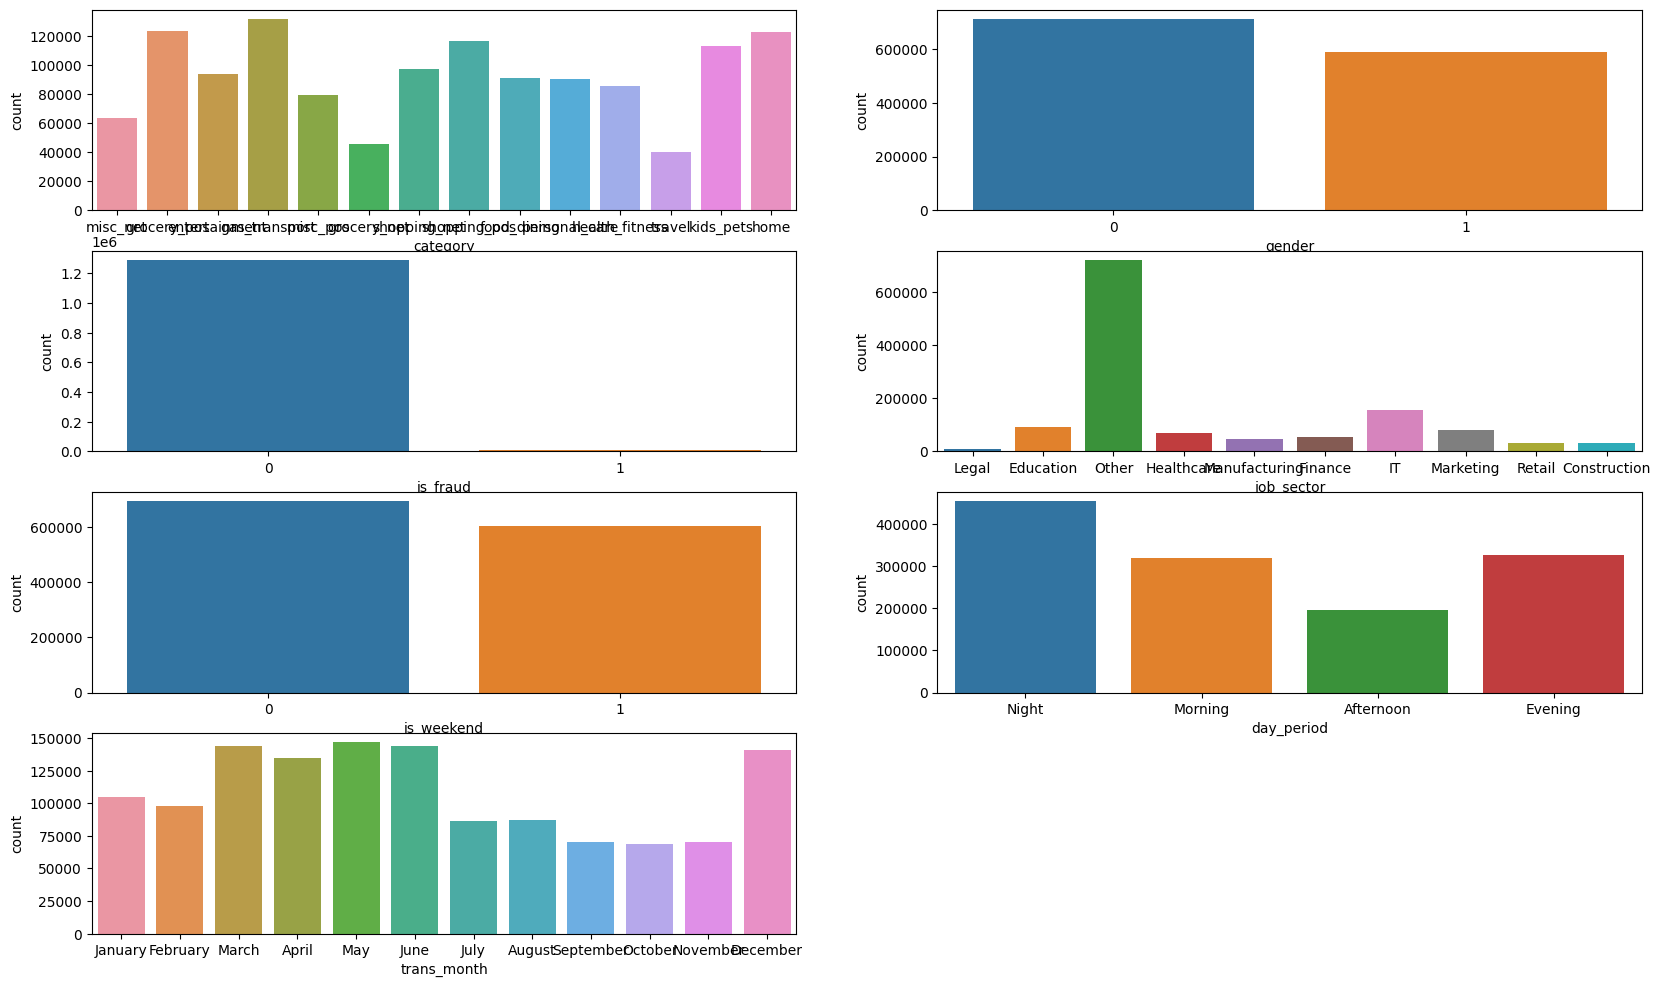

In [42]:
plt.figure(figsize = (20, 12))
cnt = 0
for column in categorical:
    cnt += 1
    plt.subplot(4, 2, cnt)
    sns.countplot(x = df[column])

Univariate Analysis

1) Categorical :

Observations
 + Female is more than male in this dataset.
 + Weekend are more than half of weekdays.
 + Lot of transaction happened at Night

2) Numerical

Observations
 + No much observations, everything looks good with neglegible outliers


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='category', ylabel='is_fraud'>

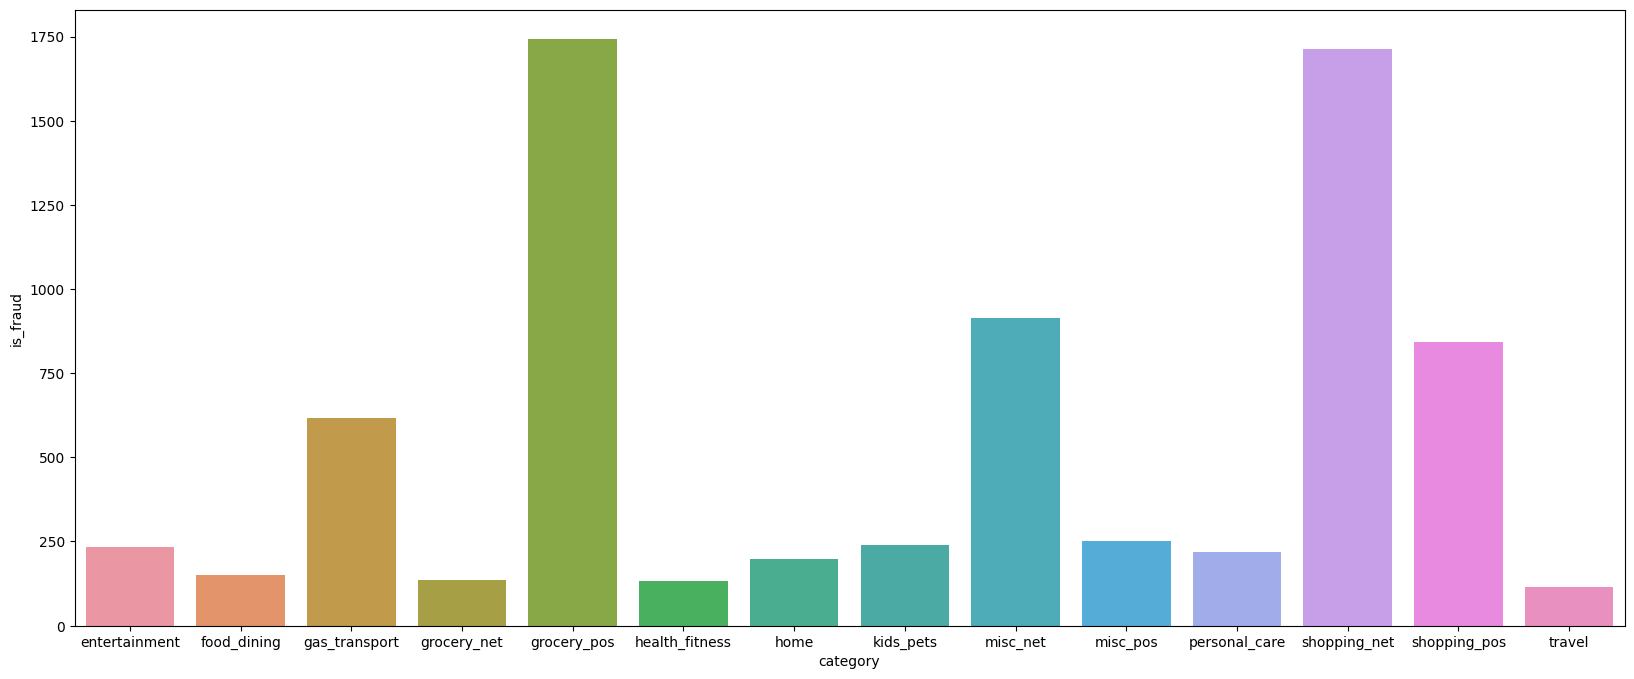

In [45]:
fraud_by_cate = df.groupby('category')['is_fraud'].sum().reset_index()

plt.figure(figsize=(20, 8))
sns.barplot(x='category', y='is_fraud', data=fraud_by_cate)

+ Most fraud seems to be originating from transactions in the 'grocery_pos' and 'shopping_net' categories. This could be due to the high volume of transactions and the nature of online and in-store purchases, which are more prone to fraudulent activities.
+ Following these, 'misc_net' and 'gas_transport' also show significant fraud, potentially due to less frequent but larger-value transactions, or because they involve services that can be harder to track and verify.

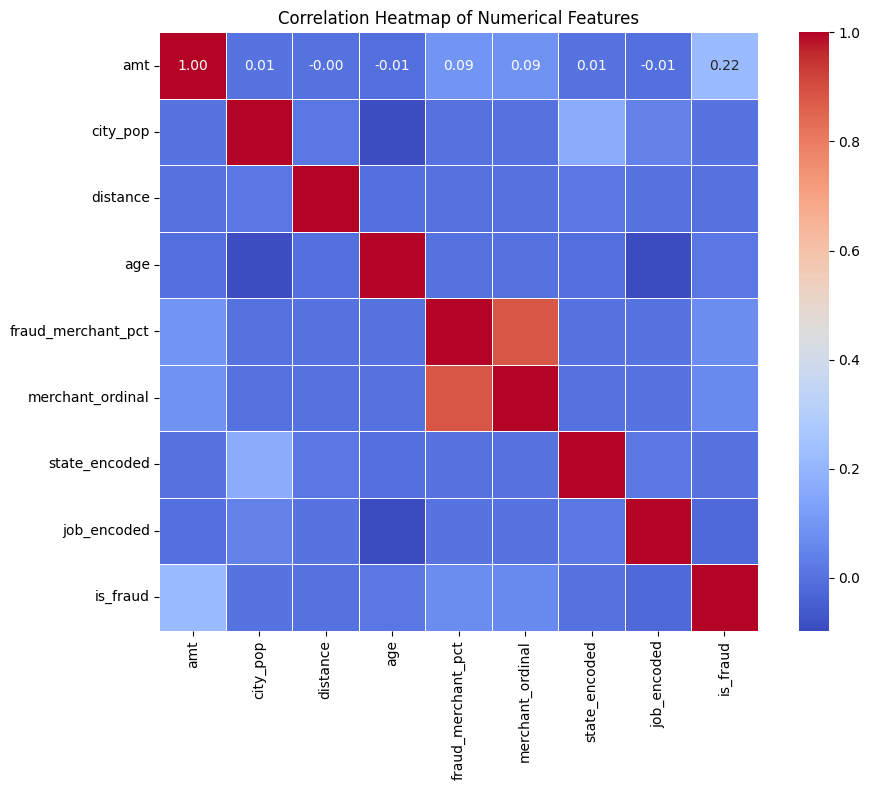

In [56]:
df_numerical = df[numerical]

# Compute the correlation matrix
corr_matrix = df_numerical.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)

# Add a title
plt.title("Correlation Heatmap of Numerical Features")

# Show the plot
plt.tight_layout()
plt.show()

1. Fraud Link:
amt has a moderate positive link with fraud (0.22), suggesting larger transactions are more likely to be flagged as fraudulent, though not strongly.
fraud_merchant_pct and merchant_ordinal are highly related, likely due to shared underlying data.

2. Weak Links:
Features like city_pop, distance, age, state_encoded, and job_encoded show little connection to fraud.

* Important Feature:
amt stands out as useful for identifying fraud, while other features may need advanced modeling to reveal hidden patterns.

In [57]:
df.drop(columns = ["is_weekend", "job_sector"], inplace = True) # drop as no related to find the fraud in transaction...

In [58]:
oe = OrdinalEncoder(categories = [["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]])
oe_period = OrdinalEncoder(categories = [["Night", "Evening", "Afternoon", "Morning"]])

In [59]:
df["trans_month"] = oe.fit_transform(df[["trans_month"]])
df["day_period"] = oe_period.fit_transform(df[["day_period"]])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is depreca

In [60]:
df.drop(columns = ["category"], inplace = True)
final_df = df

In [61]:
final_df.head()

,amt,gender,city_pop,is_fraud,age,distance,fraud_merchant_pct,merchant_ordinal,state_encoded,job_encoded,day_period,trans_month
0,4.97,0,3495,0,36,78.597568,1.420679,599,0.023341,0.002734,0.0,0.0
1,107.23,0,149,0,46,30.212176,1.078706,557,0.014594,0.003932,0.0,0.0
2,220.11,1,4154,0,62,108.206083,0.211082,215,0.004276,0.000394,0.0,0.0
3,45.00,1,1939,0,57,95.673231,0.344432,368,0.009065,0.001951,0.0,0.0
4,41.96,1,99,0,38,77.556744,0.376884,399,0.022558,0.001556,0.0,0.0


-> Based on the analysis, there is a huge gap between the number of non-fraud and fraud cases in the dataset. We can use unsupervised learning to address this problem by identifying anomalies and flagging fraud when it reaches a certain threshold.

## 2. Traning Model

In [62]:
X_train = final_df.drop(columns=['is_fraud'])
y_train = final_df['is_fraud'] # For evaluation

X_train.head()

,amt,gender,city_pop,age,distance,fraud_merchant_pct,merchant_ordinal,state_encoded,job_encoded,day_period,trans_month
0,4.97,0,3495,36,78.597568,1.420679,599,0.023341,0.002734,0.0,0.0
1,107.23,0,149,46,30.212176,1.078706,557,0.014594,0.003932,0.0,0.0
2,220.11,1,4154,62,108.206083,0.211082,215,0.004276,0.000394,0.0,0.0
3,45.00,1,1939,57,95.673231,0.344432,368,0.009065,0.001951,0.0,0.0
4,41.96,1,99,38,77.556744,0.376884,399,0.022558,0.001556,0.0,0.0


In [63]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   amt                 1296675 non-null  float64
 1   gender              1296675 non-null  int64  
 2   city_pop            1296675 non-null  int64  
 3   age                 1296675 non-null  int64  
 4   distance            1296675 non-null  float64
 5   fraud_merchant_pct  1296675 non-null  float64
 6   merchant_ordinal    1296675 non-null  int64  
 7   state_encoded       1296675 non-null  float64
 8   job_encoded         1296675 non-null  float64
 9   day_period          1296675 non-null  float64
 10  trans_month         1296675 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 108.8 MB


In [ ]:
# Standardize your data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
# Reshape for LSTM: (samples, timesteps, features)
timesteps = 1
input_dim = X_train_scaled.shape[1]

# Reshape the data for LSTM input
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, input_dim))

In [ ]:
# Build the LSTM Autoencoder model
input_layer = Input(shape=(timesteps, input_dim))
encoder = LSTM(16, activation='relu', return_sequences=True)(input_layer)
encoder = LSTM(8, activation='relu', return_sequences=False)(encoder)
decoder = RepeatVector(timesteps)(encoder)
decoder = LSTM(8, activation='relu', return_sequences=True)(decoder)
decoder = LSTM(16, activation='relu', return_sequences=True)(decoder)
output_layer = TimeDistributed(Dense(input_dim))(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

In [106]:
# Train and predict
autoencoder.fit(X_train_reshaped, X_train_reshaped, epochs=10, batch_size=32, validation_split=0.2)
X_train_reconstructed = autoencoder.predict(X_train_reshaped)

Epoch 1/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 206s 6ms/step - loss: 0.1513 - val_loss: 0.0679
Epoch 2/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 212s 6ms/step - loss: 0.0794 - val_loss: 0.0798
Epoch 3/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 209s 6ms/step - loss: 0.0853 - val_loss: 0.0429
Epoch 4/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 256s 6ms/step - loss: 0.0519 - val_loss: 0.0426
Epoch 5/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 256s 6ms/step - loss: 0.0813 - val_loss: 0.0480
Epoch 6/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 201s 6ms/step - loss: 0.0487 - val_loss: 0.0501
Epoch 7/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 200s 6ms/step - loss: 0.0981 - val_loss: 0.0440
Epoch 8/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 204s 6ms/step - loss: 0.0825 - val_loss: 0.0404
Epoch 9/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 196s 6ms/step - loss: 0.0437 - val_loss: 0.0981
Epoch 10/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 217s 6ms/step - loss: 0.0775 - val_loss: 0.0548
40522/40522 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step


In [ ]:
# Calculate the reconstruction error (Mean Squared Error)
reconstruction_error = np.mean(np.square(X_train_reshaped - X_train_reconstructed), axis=1)

In [ ]:
# Threshold
threshold = np.percentile(reconstruction_error, 96)
fraud_predictions = (reconstruction_error > threshold).astype(int)

In [ ]:
fraud_predictions_binary = np.mean(fraud_predictions, axis=1)
fraud_predictions_binary = (fraud_predictions_binary > threshold).astype(int)

In [152]:
accuracy = accuracy_score(y_train, fraud_predictions_binary)
print(f'Accuracy of train set: {accuracy:.4f}')

Accuracy of train set: 0.9124


We achieved 91% accuracy in distinguishing between non-fraud and fraud transactions. Although the accuracy is high, the number of non-fraud cases is too large, which may make the fraud prediction unreliable. Let's evaluate only the fraud cases...

In [ ]:
# Filter the rows where y_train is 1 (fraudulent transactions)
fraud_indices = y_train == 1 

# Filter fraud_predictions_binary to only include fraud cases
y_train_fraud = y_train[fraud_indices]
fraud_predictions_fraud = fraud_predictions_binary[fraud_indices]

In [153]:
accuracy_fraud = accuracy_score(y_train_fraud, fraud_predictions_fraud)
print(f'Accuracy train set on fraudulent transactions: {accuracy_fraud:.4f}')

Accuracy train set on fraudulent transactions: 0.6033


We achieved 60% accuracy in detecting fraud cases. Bravo!

## Evaluate on test batch

In [133]:
def preprocess_fraud_data(sector_bag):
    current_year = datetime.now().year
    df = pd.read_csv("/content/fraud-detection/fraudTest.csv")

    # Drop unnecessary columns
    df.drop(columns=[df.columns[0], df.columns[2], df.columns[6], df.columns[7], df.columns[9], "trans_num"], inplace=True)

    # Age
    df['dob'] = pd.to_datetime(df['dob'])
    df['age'] = current_year - df['dob'].dt.year
    df.drop(columns=["dob"], inplace=True)

    # Distance
    df["distance"] = df.apply(lambda row: haversine_distance(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)
    df.drop(columns=["lat", "long", "merch_lat", "merch_long"], inplace=True)

    # Merchant fraud percentage
    merchant_groups = df.groupby('merchant')
    fraud_percentage_dict = {}

    for merchant, group in merchant_groups:
        total_trans = group.shape[0]
        total_fraud_trans = group[group["is_fraud"] == 1].shape[0]
        fraud_percentage_dict[merchant] = (total_fraud_trans / total_trans) * 100

    df["fraud_merchant_pct"] = df["merchant"].map(fraud_percentage_dict)
    sorted_fraud_percentage = sorted(fraud_percentage_dict.items(), key=lambda x: x[1])

    merchant_ordinal_dict = {merchant: rank + 1 for rank, (merchant, _) in enumerate(sorted_fraud_percentage)}
    df["merchant_ordinal"] = df["merchant"].map(merchant_ordinal_dict)

    # State encode
    state_freq = df['state'].value_counts(normalize=True)
    df['state_encoded'] = df['state'].map(state_freq)

    # Job encode
    job_freq = df['job'].value_counts(normalize=True)
    df['job_encoded'] = df["job"].map(job_freq)

    # Gender encode
    df["gender"] = df["gender"].apply(lambda x: int(x == "M"))
    df.drop(columns=["state", "city", "merchant", "zip", "unix_time", "job", "category"], inplace=True)

    # Date features
    df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
    df["day_period"] = df["trans_date_trans_time"].dt.hour.apply(day_period)
    df["trans_month"] = df["trans_date_trans_time"].dt.month_name()
    df.drop(columns=["trans_date_trans_time"], inplace=True)

    # Ordinal encoding for month and day period
    oe = OrdinalEncoder(categories=[["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]])
    oe_period = OrdinalEncoder(categories=[["Night", "Evening", "Afternoon", "Morning"]])
    df["trans_month"] = oe.fit_transform(df[["trans_month"]])
    df["day_period"] = oe_period.fit_transform(df[["day_period"]])



    X_test = df.drop(columns=['is_fraud'])
    y_test = df['is_fraud']

    return X_test, y_test


In [134]:
X_test, y_test = preprocess_fraud_data(sector_bag)

In [135]:
# Standardize your data
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Reshape for LSTM
timesteps = 1
input_dim = X_test_scaled.shape[1]

# Reshape the data for LSTM input
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, input_dim))

# Predict
X_test_reconstructed = autoencoder.predict(X_test_reshaped)

17367/17367 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step


In [154]:
# Calculate the reconstruction error (Mean Squared Error)
reconstruction_error = np.mean(np.square(X_test_reshaped - X_test_reconstructed), axis=1)

# Set a threshold
threshold = np.percentile(reconstruction_error, 96)
fraud_predictions = (reconstruction_error > threshold).astype(int)

# Calculate the mean or sum of errors across the columns (time steps)
fraud_predictions_binary = np.mean(fraud_predictions, axis=1)
fraud_predictions_binary = (fraud_predictions_binary > threshold).astype(int)

# Compare
accuracy_test = accuracy_score(y_test, fraud_predictions_binary)
print(f'Accuracy test set: {accuracy_test:.4f}')

Accuracy test set: 0.9093


The accuracy on the entire test set is quite similar to the training set (~90%)

In [155]:
from sklearn.metrics import accuracy_score

fraud_indices = y_test == 1 
y_test_fraud = y_test[fraud_indices]
fraud_predictions_fraud = fraud_predictions_binary[fraud_indices]

accuracy_fraud_test = accuracy_score(y_test_fraud, fraud_predictions_fraud)
print(f'Accuracy of test set on fraudulent transactions: {accuracy_fraud_test:.4f}')

Accuracy of test set on fraudulent transactions: 0.5897


The accuracy on fraud data is similar as well, with only a small difference between the training set (60%) and the test set (59%)

Let's conclude the outcomes from those 2 dataset when using LSTM Autoencoder to predict the fraud transcations

In [ ]:
accuracy_labels = ['accuracy_test', 'accuracy_train', 'accuracy_fraud_test', 'accuracy_fraud_train']
accuracy_values = [accuracy_test, accuracy, accuracy_fraud_test, accuracy_fraud]

In [162]:
# Bar
bar_width = 0.35 
x_pos = np.arange(2)

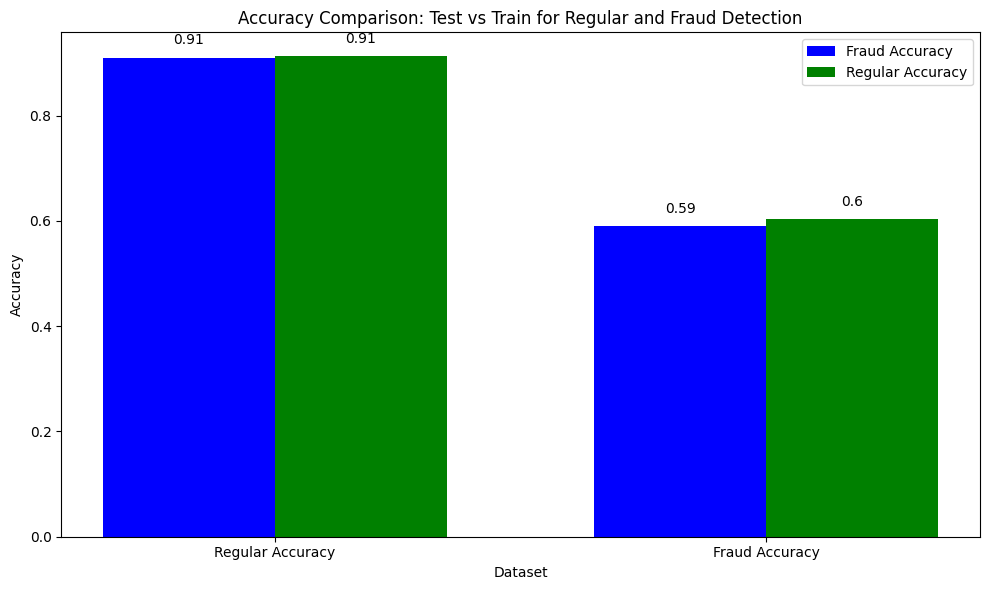

In [165]:
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x_pos - bar_width/2, [accuracy_values[0], accuracy_values[2]], bar_width, color='blue', label='Fraud Accuracy')
bars2 = ax.bar(x_pos + bar_width/2, [accuracy_values[1], accuracy_values[3]], bar_width, color='green', label='Regular Accuracy')

ax.set_xlabel('Dataset')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison: Test vs Train for Regular and Fraud Detection')

ax.set_xticks(x_pos)
ax.set_xticklabels(['Regular Accuracy', 'Fraud Accuracy'])


for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom')


ax.legend()
plt.tight_layout()
plt.show()


# Thank you for your reading!